# Introduction

**Table of contents**<a id='toc0_'></a>    
- 1. [VS Code](#toc1_)    
- 2. [Jupyter notebooks](#toc2_)    
- 3. [US GDP data from FRED](#toc3_)    
- 4. [Solving the consumer problem with a numerical optimizer](#toc4_)    
- 5. [Solving the consumer problem with a brute force grid search](#toc5_)    
- 6. [Using modules](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[VS Code](#toc0_)

1. An **integrated development environment (IDE)** for many languages
2. **This window:** *Editor*
3. **Side-bar on left:** *Explorer*
4. `.ipynb` are **Jupyter notebooks** with text and code
5. `.py` are files with **Python code**

**Change theme?** Try `Ctrl+Shift+P` and search for "theme".

## 2. <a id='toc2_'></a>[Jupyter notebooks](#toc0_)

This is a `text cell`, or more precisely a `markdown cell`.

* Pres <kbd>Enter</kbd> to go to *edit mode*
* Pres <kbd>Esc</kbd> to go to *command mode*
* Pres <kbd>Ctrl+Enter</kbd> to *run* the cell
* Pres <kbd>Shift+Enter</kbd> to *run* the cell + advance

We can make lists:

1. **First** item
2. *Second* item
3. ~~Third~~ item

We can also do LaTeX math, e.g. inline $\alpha^2$, or

$$
X = \int_0^{\infty} \frac{x}{x+1} dx
$$

or

$$
\begin{align*}
D &= 20 - 3p   \\
S &= 2p - 5 \\
\end{align*}
$$

**Markdown:** Guide on [markdownguide.org/basic-syntax/](https://www.markdownguide.org/basic-syntax/)

`Code cells`:

In [1]:
# this is (a comment in) a code cell
# let us do some calculations
a = 20
b = 30
c = a+b

# let us print the results (shown below the cell)
print(c)

50


We can now write some more text, and continue with our calculations.

In [2]:
d = c*2
print(d)
print(c*3)

100
150


**Task:** Write a new cell with `e = d**2` and run it.

>**Useful shortcuts**: See this [guide](https://sites.google.com/view/numeconcph-progecon/guides/vscode).
>1. Press `A` to *create* new code cell *above*
>1. Press `B` to *create* new code cell *below* 
>2. Press `M` to change to `markdown cell`
>3. Press `Y` to change to `code cell`
>4. Press `D+D` to *delete* cell
><br></br>

## 3. <a id='toc3_'></a>[US GDP data from FRED](#toc0_)

Imports:

In [3]:
from fredapi import Fred
import matplotlib.pyplot as plt

# some personal plot settings
plt.rcParams.update({"axes.grid":True,
                     "grid.color":"black",
                     "grid.alpha":"0.25",
                     "grid.linestyle":"--"})

Access fred using API key:

In [4]:
txtfile = 'c:/Users/gmf123/Dropbox/fredapi.txt'
with open(txtfile,'r') as f: fred_api_key = f.read()
fred = Fred(api_key=fred_api_key)

Plot real US GDP in levels:

In [5]:
fred.search('GDPC1')[['title','units','seasonal_adjustment']].T

series id,GDPC1
title,Real Gross Domestic Product
units,Billions of Chained 2017 Dollars
seasonal_adjustment,Seasonally Adjusted Annual Rate


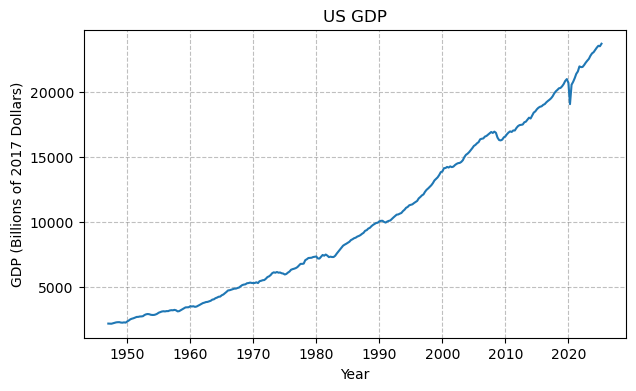

In [6]:
# a. get US GDP data
GDPC1 = fred.get_series('GDPC1')

# b. plot
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ax.set_title('US GDP')

ax.plot(GDPC1.index, GDPC1.values)

ax.set_xlabel('Year')
ax.set_ylabel('GDP (Billions of 2017 Dollars)');  

Plot real GDP growth rate with NBER recessions:

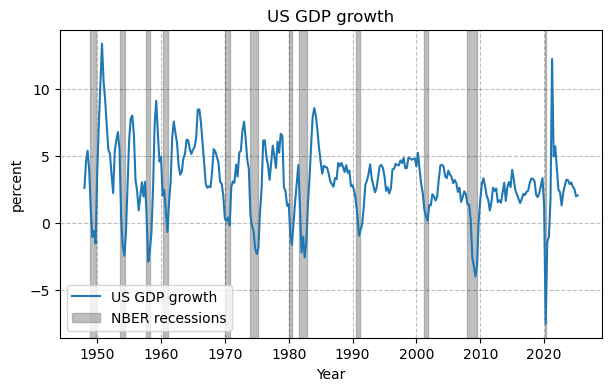

In [7]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ax.set_title('US GDP growth')

# GDP growth rate
x = GDPC1.index[4:]
y = (GDPC1.values[4:]/GDPC1.values[:-4]-1)*100
ax.plot(x,y,label='US GDP growth')

# NBER recessions
nber_recessions = fred.get_series('USREC')
I = nber_recessions.index > GDPC1.index[0]
y1, y2 = ax.get_ylim()
ax.fill_between(nber_recessions.index[I],y1,y2,
                where=nber_recessions[I]==1,
                color='gray',alpha=0.5,
                label='NBER recessions')

# limits, labels, legend
ax.set_ylim(y1,y2)
ax.set_xlabel('Year')
ax.set_ylabel('percent');  
ax.legend(loc='lower left');

## 4. <a id='toc4_'></a>[Solving the consumer problem with a numerical optimizer](#toc0_)

Consider the following consumer problem:

$$
\begin{aligned}
V(p_{1},p_{2},m) & = \max_{x_{1},x_{2}} x_{1}^{\alpha}x_{2}^{1-\alpha}\\
 & \text{s.t.}\\
p_{1}x_{1}+p_{2}x_{2} & \leq m \\
x_{1},x_{2} & \geq 0 \\
p_{1},p_{2},m & > 0
\end{aligned}
$$

We can solve this problem _numerically_ in a few lines of code.

1. Choose some **parameters**:

In [8]:
alpha = 0.5
m = 10
p1 = 1
p2 = 2

**Note:** Try to click on *Variables* above to see the value of all variables.

2. The **consumer objective** is:

In [9]:
def utility(x1,x2,alpha):
    return x1**alpha * x2**(1-alpha)

# def function_name(inputs):
#    return outputs

def value_of_choice(x1,alpha,m,p1,p2):
    
    # a. all income not spent on the first good
    #    is spent on the second
    x2 = (m-p1*x1)/p2 
    
    # b. the resulting utility is
    u = utility(x1,x2,alpha)
    
    return u

3. We can now use a function from the `scipy` module to **solve the consumer problem**.

In [10]:
# a. load external module from scipy
from scipy import optimize

# b. make value-of-choice as a funciton of only x1 
obj = lambda x1: -value_of_choice(x1,alpha,m,p1,p2)

# output = lambda input: expression(input)

# c. call numerical minimizer
solution = optimize.minimize_scalar(obj,bounds=(0,m/p1))

# d. print result
u = -solution.fun
x1 = solution.x
x2 = (m-x1*p1)/p2
print(x1,x2,u)

4.999999999999999 2.5000000000000004 3.5355339059327373


**Task**: Solve the consumer problem with the CES utility function.

$$
u(x_1,x_2) = (\alpha x_1^{-\beta} + (1-\alpha) x_2^{-\beta})^{-1/\beta}
$$

In [11]:
# a. choose parameters
alpha = 0.5
beta = 0.000001
m = 10
p1 = 1
p2 = 2

# b. value-of-choice
def utility_ces(x1,x2,alpha,beta):
    if x1 > 0 and x2 > 0:
        return (alpha*x1**(-beta)+(1-alpha)*x2**(-beta))**(-1/beta) 
    else:
        return 0

def value_of_choice_ces(x1,alpha,beta,m,p1,p2):
    x2 = (m-p1*x1)/p2
    u = utility_ces(x1,x2,alpha,beta)
    return u

# c. objective
obj = lambda x1: -value_of_choice_ces(x1,alpha,beta,m,p1,p2)

# d. solve
solution = optimize.minimize_scalar(obj,bounds=(0,m/p1))

# e. result
u_ces = -solution.fun
x1_ces = solution.x
x2_ces = (m-x1_ces*p1)/p2
print(x1_ces,x2_ces,u_ces)

4.99995818905239 2.500020905473805 3.535533693620822


## 5. <a id='toc5_'></a>[Solving the consumer problem with a brute force grid search](#toc0_)

Create vectors of potential choices:

In [12]:
import numpy as np
N = 100
x1_vec = np.linspace(0,10,N) # try to hover over "linspace"
x2_vec = np.linspace(0,10,N)

Use trial-and-error:

In [13]:
x1_best = np.nan # nan = Not-a-Number
x2_best = np.nan 
u_best = -np.inf # the worst it can get

for x1 in x1_vec:
    for x2 in x2_vec:
        
        if p1*x1 + p2*x2 <= m: # expenditure <= income

            u_now = utility_ces(x1,x2,alpha,beta)
        
            if u_now > u_best: # better?
                u_best = u_now # save best utility yet seen
                x1_best = x1 # ... and choice
                x2_best = x2

print(x1_best,x2_best,u_best)

4.94949494949495 2.525252525252525 3.5353533352032596


**Problem:** We get a lower utility than with the numerical optimizer...

In [14]:
print(u_best-u_ces)

-0.0001803584175625872


**Task:** Can you improve the brute force solution?

**Socrative room:** PROGECON

## 6. <a id='toc6_'></a>[Using modules](#toc0_)

A **module** is a **.py**-file with functions you import and can then call in the notebook.

Try to open **mymodule.py** and have a look.

In [15]:
import mymodule

In [16]:
x = 5
y = mymodule.myfunction(x) # try pressing F12 with cursor at "myfunction"
print(y)

25


**Task**: Create `mynewmodule.py` with a function you choose and call it from this notebook.